In [1]:
#imports
import logging
import torch
# set seed
import pandas as pd
import numpy as np
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import PLSRegression
import matplotlib.pyplot as plt

from sk_models import PLSRegression, StandardScaler,LocalWeightedRegression,PLSLWR,LinearRidge
from river_models import *

from river import stream,linear_model,preprocessing, ensemble, metrics, optim
from river.neighbors import KNNRegressor 
from sklearn.metrics import mean_squared_error
from river.utils import dict2numpy, numpy2dict

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and output directories

#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "PLN7.csv"
id_cols =["db_id","sample_id"]
output_cols = None
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/6.03_v7") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\6.03_v7\PLN7


In [3]:
data = pd.read_csv(data_file)
data=data.sample(frac=1,random_state=random_state)

pre_ind =[i for i in range(0,10000)]
pretrain_ind,pretest_ind = train_test_split(pre_ind,train_size=5/6,random_state=random_state,shuffle=False)
stream_ind = [i for i in range(10000,110000)]

pretrain_data =  ut.TabularDataset(data.iloc[pretrain_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
pretest_data = ut.TabularDataset(data.iloc[pretest_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
stream_data = ut.TabularDataset(data.iloc[stream_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)

nrow, ncol = data.shape
nrow_train = len(pretrain_data)
nrow_test = len(pretest_data)
nrow_stream = len(stream_data)

print(f"train: {nrow_train}, test: {nrow_test}, stream: {nrow_stream}")

train: 8333, test: 1667, stream: 100000


In [4]:
pls_deep_model_dir = Path("D:/workspace/lazydeep/experiments/1.01/PLN7")
pls_deep_model = torch.load(pls_deep_model_dir/"models"/"random_82"/"_model")
pls_deep_model.load_state(pls_deep_model_dir/"models"/"random_82"/"_final")
pls_scaler = PLSRegression(n_components=34).from_state(PLSRegression(n_components=34).load_state(deep_model_dir/'preprocessing'/f"_final"))                       

                        
std_deep_model_dir = Path("D:/workspace/lazydeep/experiments/2.00/PLN7")
std_deep_model = torch.load(std_deep_model_dir/"models"/"random_29"/"_model")
std_deep_model.load_state(std_deep_model_dir/"models"/"random_29"/"_final")
std_scaler = StandardScaler().from_state(StandardScaler().load_state(deep_model_dir/'preprocessing'/f"_final"))                



alpha = 0.01
lam = 1
river_models = {
                'std-deep':(StreamWrapper(std_scaler)|StreamDeep(deep_model))
               'pls-deep':(StreamWrapper(pls_scaler)|StreamDeep(pls_deep_model))
                'std-deep-lwr':(StreamWrapper(std_scaler)|StreamDeep(deep_model)|StreamLocalWeightedRegression(n_neighbors=1000,floor=True))
                'pls-deep-lwr':(StreamWrapper(pls_scaler)|StreamDeep(pls_deep_model)|StreamLocalWeightedRegression(n_neighbors=1000,floor=True))
               'std-deep-lwr-s3':(StreamWrapper(std_scaler)|StreamDeep(deep_model)|BaggingRegressor2(n_models=3,seed=seed,
                    model = StreamLocalWeightedRegression(n_neighbors=1000,floor=True))),
               'pls-deep-lwr-s3':(StreamWrapper(pls_scaler)|StreamDeep(pls_deep_model)|BaggingRegressor2(n_models=3,seed=seed,
                    model = StreamLocalWeightedRegression(n_neighbors=1000,floor=True))),
              'std-deep-lwr-s11':(StreamWrapper(std_scaler)|StreamDeep(deep_model)|BaggingRegressor2(n_models=11,seed=seed,
                    model = StreamLocalWeightedRegression(n_neighbors=1000,floor=True))),
               'pls-deep-lwr-s11':(StreamWrapper(pls_scaler)|StreamDeep(pls_deep_model)|BaggingRegressor2(n_models=11,seed=seed,
                    model = StreamLocalWeightedRegression(n_neighbors=1000,floor=True)))
               }

#setup our metrics and stores of results
full_set = river_models.keys()
metrics = {'R2':{name:metrics.R2() for name in full_set},
           'R2_rolling':{name:RollingR2(window_size=1000) for name in full_set},
           'MSE':{name:metrics.MSE() for name in river_models.keys()},
           'MSE_rolling':{name:RollingMSE(window_size=1000) for name in full_set}
          }

In [5]:
full_set = river_models.keys()
metrics = {'R2':{name:metrics.R2() for name in full_set},
           'R2_rolling': {name:RollingR2(window_size=1000) for name in full_set},
           'MSE':{name:metrics.MSE() for name in river_models.keys()},
           'MSE_rolling':{name:RollingMSE(window_size=1000) for name in full_set}
          }

In [6]:
_,_,river_models,metrics = prequential_evaluate(pretrain_data,river_models,metrics,pretrain = len(pretrain_data),num_its=len(pretrain_data))

  0%|          | 0/8333 [00:00<?, ?it/s]

In [7]:
preds_test,scores_test,metrics = score_evaluate(pretest_data,river_models,metrics,num_its=len(pretest_data))

  0%|          | 0/1667 [00:00<?, ?it/s]

In [8]:
preds_stream, scores_stream,river_models,metrics = prequential_evaluate(stream_data,river_models,metrics,pretrain=0,num_its=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
def zip_dict(dict1,dict2):
 
    dict12 = {k:dict1[k]+dict2[k] for k in dict1.keys()}   
    return dict12
 
def zip_nested_dict(dict1,dict2):
    dict12 = {}
    
    for k in dict1.keys():
        dict12[k] = {name:dict1[k][name]+dict2[k][name] for name in dict1[k].keys()}
    return dict12

In [10]:
preds = zip_dict(preds_test,preds_stream)

In [11]:
scores = zip_nested_dict(scores_test,scores_stream)

In [12]:
preds_df = pd.DataFrame(preds)
preds_df.to_csv(log_dir/"preds_df.csv")


In [13]:
#findings
#1) preprocessing works, random lr things for lr don't
#) standardisation asks as regularisation

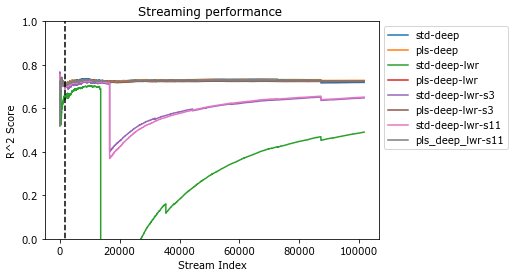

In [14]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance ")

scores_df = pd.DataFrame(scores['R2'])
scores_df.to_csv(log_dir/"r2_scores.csv")
for (columnName, columnData) in scores_df.iteritems():

    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2.png",bbox_inches='tight')


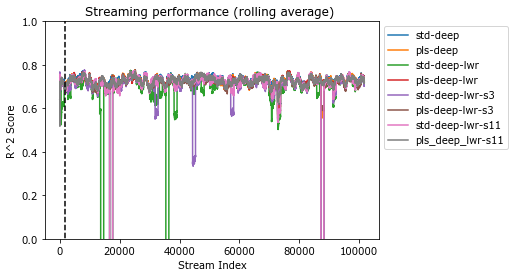

In [15]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance (rolling average) ")
    
scores_df = pd.DataFrame(scores['R2_rolling'])
scores_df.to_csv(log_dir/"r2_scores_rolling.csv")
for (columnName, columnData) in scores_df.iteritems():
    columnData
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2.png",bbox_inches='tight')

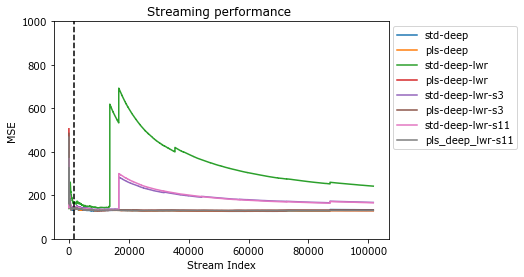

In [16]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance ")

scores_df = pd.DataFrame(scores['MSE'])
scores_df.to_csv(log_dir/"MSE.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[0,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot.png",bbox_inches='tight')
ax.set_ylim(0,1000)
plt.savefig(log_dir / f"mse_plot_v2.png",bbox_inches='tight')

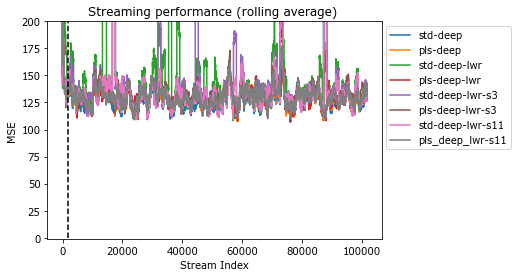

In [17]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance (rolling average) ")

scores_df = pd.DataFrame(scores['MSE_rolling'])
scores_df.to_csv(log_dir/"MSE_rolling.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[0,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(-1,200)
plt.savefig(log_dir / f"mse_plot_rolling_v2.png",bbox_inches='tight')

std-deep, R^2 = 0.848769706128346, MSE = 133.40601677494345
pls-deep, R^2 = 0.8539144851844163, MSE = 129.005352509592
std-deep-lwr, R^2 = 0.744841568627234, MSE = 242.15388405882325
pls-deep-lwr, R^2 = 0.8519978984830797, MSE = 130.3598380430419
std-deep-lwr-s3, R^2 = 0.8117024871669328, MSE = 167.2783834436071
pls-deep-lwr-s3, R^2 = 0.850281850923497, MSE = 131.832434791482
std-deep-lwr-s11, R^2 = 0.8132547371486911, MSE = 165.5974221256895
pls_deep_lwr-s11, R^2 = 0.852176445683747, MSE = 130.22595390544595


(0.0, 500.0)

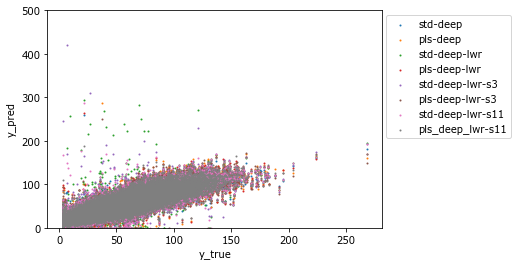

In [ ]:
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

fig, ax = plt.subplots()
ax.set_ylabel('y_pred')
ax.set_xlabel('y_true')

for (columnName, columnData) in preds_df.iteritems():
        if not columnName == 'y':
            ax.scatter(preds_df['y'],columnData,label = f"{columnName}",s=1)
            
            corr_coef = scipy.stats.pearsonr(columnData, preds_df['y'])
            #slope, intercept, r, p, stderr = scipy.stats.linregress(columnData, preds_df['y'])
            loss = mean_squared_error(preds_df['y'], columnData)
            mae = mean_absolute_error(preds_df['y'], columnData)    
            print(f"{columnName}, R^2 = {corr_coef[0]}, MSE = {loss}")
            
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylim(0,500)

In [24]:
scores_df_rolling = pd.DataFrame(scores['R2_rolling'])
scores_df_total = pd.DataFrame(scores['R2'])

In [25]:
def take_subset_by_str(dataset,s,reverse=False):
    col_names = dataset.columns.tolist()
    if reverse:
        encoding = [i for i in col_names if not (s in i)]
    else:
        encoding = [i for i in col_names if (s in i)]
    return dataset[encoding]

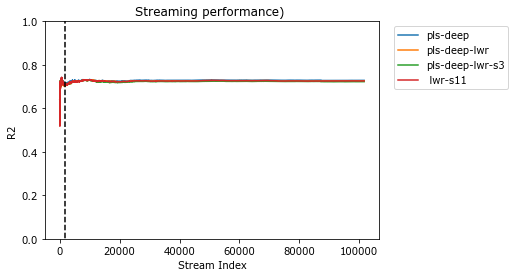

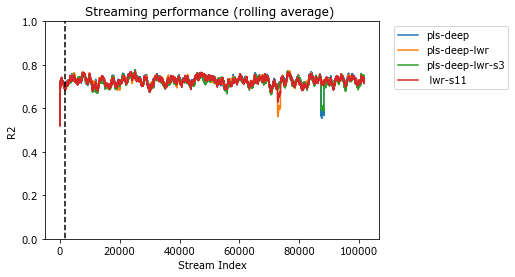

In [27]:
subset = take_subset_by_str(scores_df_total ,'pls')
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance) ")


for (columnName, columnData) in subset.iteritems():
    ax.plot(columnData.index,columnData,label = f"{columnName.replace('pls_deep_',' ').replace('pls_deep','base_model')}",linewidth=1.5)
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pls.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2_pls.png",bbox_inches='tight')

subset = take_subset_by_str(scores_df_rolling ,'pls')
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance (rolling average) ")


for (columnName, columnData) in subset.iteritems():
    ax.plot(columnData.index,columnData,label = f"{columnName.replace('pls_deep_',' ').replace('pls_deep','base_model')}",linewidth=1.5)
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling_pls.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2_pls.png",bbox_inches='tight')
    
    

In [ ]:
subset = take_subset_by_str(scores_df_total ,'pls',reverse=True)
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance ")


for (columnName, columnData) in subset.iteritems():
    ax.plot(columnData.index,columnData,label =  f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_deep.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2_deep.png",bbox_inches='tight')

subset = take_subset_by_str(scores_df_rolling ,'pls',reverse=True)
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance (rolling average) ")


for (columnName, columnData) in subset.iteritems():
    ax.plot(columnData.index,columnData,label =  f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling_deep.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2_deep.png",bbox_inches='tight')
    